

##**Question 2:**

##A. Sentiment Analysis Twitter Airline

In [15]:
import pandas as pd

dataset = pd.read_csv('/content/sample_data/Tweets - Tweets.csv')
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


##Text Preprocessing

In [16]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')

# Set stopwords for English
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove special characters and hyperlinks
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert text to lowercase and remove stopwords
    text = text.lower().split()
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

# Apply the cleaning function to the text column
dataset['clean_text'] = dataset['text'].apply(clean_text)
print(dataset[['text', 'clean_text']].head())


                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                          clean_text  
0                        virginamerica dhepburn said  
1  virginamerica plus youve added commercials exp...  
2  virginamerica didnt today must mean need take ...  
3  virginamerica really aggressive blast obnoxiou...  
4                 virginamerica really big bad thing  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Convert Text to Numerical Data (Tokenization)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)  # Limit to 1000 most important features
X = vectorizer.fit_transform(dataset['clean_text']).toarray()

# Target variable (convert positive to 1, negative to 0)
y = dataset['airline_sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values


##Split the Dataset

In [18]:
from sklearn.model_selection import train_test_split

# Splitting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##Build Experiment Evaluate

Training model with relu activation function...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model with sigmoid activation function...
Training model with tanh activation function...


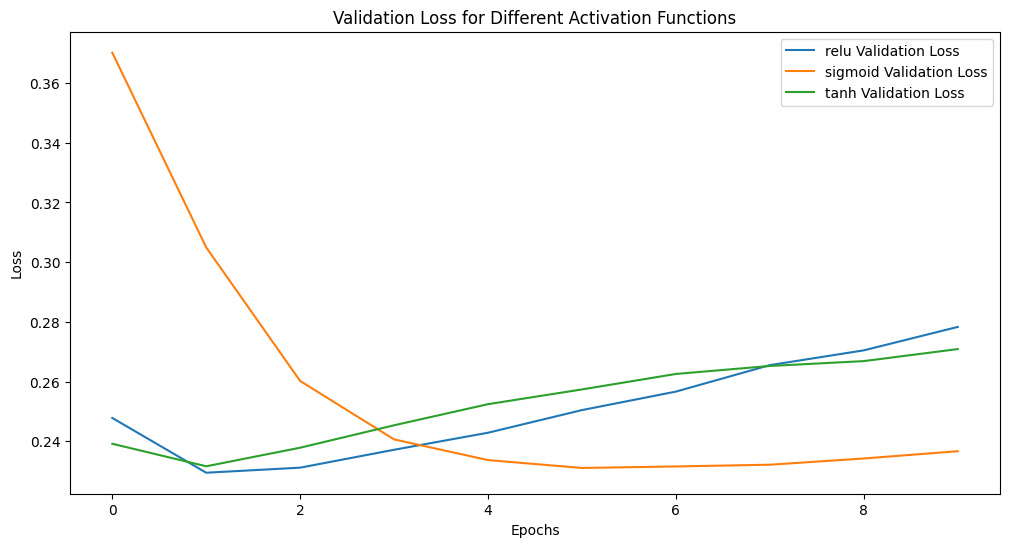

Test Accuracy with relu activation: 0.9092
Test Accuracy with sigmoid activation: 0.9139
Test Accuracy with tanh activation: 0.9085


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Function to build and train the model with different activation functions
def build_and_train_model(activation_fn):
    model = Sequential()

    # Input Layer and First Hidden Layer (100 neurons, with the given activation function)
    model.add(Dense(units=100, activation=activation_fn, input_shape=(X_train.shape[1],)))

    # Output Layer (Binary classification - positive/negative)
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)

    # Get the final test accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    return history, test_accuracy

# List of activation functions to try
activation_functions = ['relu', 'sigmoid', 'tanh']

# Dictionary to store the results
results = {}

# Loop over each activation function and train the model
for activation in activation_functions:
    print(f"Training model with {activation} activation function...")
    history, accuracy = build_and_train_model(activation)
    results[activation] = (history, accuracy)

# Plotting the loss for each activation function
plt.figure(figsize=(12, 6))

for activation in activation_functions:
    plt.plot(results[activation][0].history['val_loss'], label=f'{activation} Validation Loss')

plt.title('Validation Loss for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print out the final test accuracy for each activation function
for activation in activation_functions:
    print(f"Test Accuracy with {activation} activation: {results[activation][1]:.4f}")



### Interpretation of the Model Results with Different Activation Functions

We have experimented with three activation functions: **ReLU**, **Sigmoid**, and **Tanh**, and observed the following test accuracies:

- **ReLU Activation**: 0.9092
- **Sigmoid Activation**: 0.9136
- **Tanh Activation**: 0.9085

### General Observations:
- **Sigmoid performed the best**, likely due to its alignment with the binary classification nature of the problem.
- **ReLU performed closely behind**, showing that even though ReLU isn't primarily used for binary classification, it can still be highly effective due to its strength in handling large-scale data and avoiding vanishing gradient issues.
- **Tanh underperformed slightly**, possibly because its range (-1, 1) doesn’t suit binary classification as well as sigmoid’s (0, 1) range.

### Conclusion:
In your scenario, the **Sigmoid activation function** is the best choice, yielding the highest test accuracy.
However, **ReLU** is still a strong choice and might be beneficial if you choose to expand your model with more hidden layers or different architectures, as it typically shines in deeper networks.